In [350]:
client.shutdown()

In [1]:
import ipyparallel as ipp

NCPU = 4
cluster = ipp.Cluster(engines="mpi", n=NCPU)
client = cluster.start_and_connect_sync()

print("Client IDs:", client.ids)

Starting 4 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


  0%|          | 0/4 [00:00<?, ?engine/s]

Client IDs: [0, 1, 2, 3]


In [2]:
client.wait_for_engines(NCPU)
client.activate()

<DirectView all>

In [3]:
%%px

import numpy as np
from mpi4py import MPI
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import matplotlib.lines as lines
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.animation as animation
import ipyparallel as ipp
import math

In [4]:
%%px
# Parallelization functions

def grid_division(NX, NY):
    if NX < NY:
        sectsX=int(np.floor(np.sqrt(size*NX/NY)))
        sectsY=int(np.floor(size/sectsX))
        print('We have {} fields in x-direction and {} in y-direction'.format(sectsX,sectsY))
        print('How do the fractions look like?')
        print('NX/NY={} and sectsX/sectsY = {}\n'.format(NX/NY,sectsX/sectsY))
    elif NX > NY:
        sectsY=int(np.floor(np.sqrt(size*NY/NX)))
        sectsX=int(np.floor(size/sectsY))
        print('We have {} fields in x-direction and {} in y-direction'.format(sectsX,sectsY))
        print('How do the fractions look like?')
        print('NX/NY={} and sectsX/sectsY = {}\n'.format(NX/NY,sectsX/sectsY))
    elif NX==NY:
        sectsY=int(np.floor(np.sqrt(size)))
        sectsX=int(size/sectsY)
        if rank == 0: print('In the case of equal size we divide the processes as {} and {}'.format(sectsX,sectsY))

    sectsX=int(np.floor(np.sqrt(size)))
    sectsY=int(size//sectsX)

    nxsub = NX//sectsX+2
    nysub = NY//sectsY+2
    boundary_k=[False,False,False,False]
    cartcomm=comm.Create_cart(dims=[sectsX,sectsY],periods=[True,True],reorder=False)
    rcoords = cartcomm.Get_coords(rank)

    sR,dR = cartcomm.Shift(1,1)
    sL,dL = cartcomm.Shift(1,-1)
    sU,dU = cartcomm.Shift(0,-1)
    sD,dD = cartcomm.Shift(0,1)

    sd = np.array([sR,dR,sL,dL,sU,dU,sD,dD], dtype = int)
    
    return sectsX, sectsY, nxsub, nysub, boundary_k, cartcomm, rcoords, sd


# Communication between subdomains
def Communicate(c,cartcomm,sd):
    recvbuf = np.zeros(c[:,1,:].shape)
    sR,dR,sL,dL,sU,dU,sD,dD = sd
    # Send to right which is destination rigth (dR) and receive from left which is source right (sR)
    # print(rank,'Right, source',sR,'destination',dR)
    sendbuf = c[:,-2,:].copy() # Send the second last column to dR
#     print(recvbuf.shape, sendbuf.shape)
    cartcomm.Sendrecv(sendbuf, dR, recvbuf = recvbuf, source = sL)
    c[:,0,:] = recvbuf # received into the 0th column from sR
    # Send to left and receive from right
    #print(rank,'Left, source',sL,'destination',dL)
    sendbuf = c[:,1,:].copy()
    cartcomm.Sendrecv(sendbuf, dL, recvbuf = recvbuf, source = sR)
    c[:,-1,:] = recvbuf
    # Send to up and receive from down
    #print(rank,'Up, source',sU,'destination',dU)
    sendbuf = c[:,:,1].copy()
    cartcomm.Sendrecv(sendbuf, dU, recvbuf = recvbuf, source = sD)
    c[:,:,-1] = recvbuf
    # Send to down and receive from up
    #print(rank,'Down, source',sD,'destination',dD)
    sendbuf = c[:,:,-2].copy()
    cartcomm.Sendrecv(sendbuf, dD, recvbuf = recvbuf, source = sU)
    c[:,:,0]=recvbuf
#
    return c

def plot_gathered():
    #
    c_full_range = np.zeros((NX*NY))
    comm.Gather(c[1:-1,1:-1].reshape((nxsub-2)*(nysub-2)), c_full_range, root = 0)
    rcoords_x = comm.gather(rcoords[0], root=0)
    rcoords_y = comm.gather(rcoords[1], root=0)
    if rank == 0:
        fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    #
        X0, Y0 = np.meshgrid(np.arange(NX),np.arange(NY))
        xy = np.array([rcoords_x,rcoords_y]).T
        c_plot = np.zeros((NX,NY))
        #
        for i in np.arange(sectsX):
            for j in np.arange(sectsY):
                k = i*sectsX+j
                xlo = NX//sectsX*xy[k,1]
                xhi = NX//sectsX*(xy[k,1]+1)
                ylo = NY//sectsY*xy[k,0]
                yhi = NY//sectsY*(xy[k,0]+1)
                clo = k*NX*NY//(sectsX*sectsY)
                chi = (k+1)*NX*NY//(sectsX*sectsY)
                #print('{} to {} into {} {} to {} {}'.format(clo,chi,xlo,ylo,xhi,yhi))
                #print((xhi-xlo)*(yhi-ylo),chi-clo)
                c_plot[xlo:xhi,ylo:yhi] = c_full_range[clo:chi].reshape(NX//sectsX,NY//sectsY)
    #            
        ax.plot_surface(X0, Y0, c_plot, cmap=cm.coolwarm,linewidth=0, antialiased=False)
    #
    
def get_coordinates_of_rank(rank):
    xlo = NX//sectsX*rcoords[1]
    xhi = NX//sectsX*(rcoords[1]+1)
    ylo = NY//sectsY*rcoords[0]
    yhi = NY//sectsY*(rcoords[0]+1)
#     print(rcoords, xlo, xhi, ylo, yhi)
    return xlo, xhi, ylo, yhi

In [43]:
%%px

comm = MPI.COMM_WORLD      # start the communicator assign to comm
size = comm.Get_size()     # get the size and assign to size
rank = comm.Get_rank()     # get the rank and assign to rank
print('Rank/Size {}/{}'.format(rank,size))

LEFT = "left"
RIGHT = "right"
TOP = "top"
BOTTOM = "bottom"

NX = 300
NY = 300

#nx = 1600
dx = 0.1  # = dy
nt = 10000  # timesteps to iterate
dt = 0.001  # timestep length
D = 1  # diffusion constant

sectsX, sectsY, nxsub, nysub, boundary_k, cartcomm, rcoords, sd = grid_division(NX,NY)

# Define the gridpoints
# x = np.arange(rcoords[0]*NX//sectsX,(rcoords[0]+1)*NX//sectsX)*dx
# y = np.arange(rcoords[1]*NY//sectsX,(rcoords[1]+1)*NY//sectsY)*dx
# X,Y = np.meshgrid(x,y)
X, Y = np.meshgrid(np.arange(0,NX), np.arange(0,NY))
print(X.shape, Y.shape)
#
sigma0 = 30*dx

allrcoords = comm.gather(rcoords,root = 0)
allDestSourBuf = np.zeros(size*8, dtype = int)
comm.Gather(sd, allDestSourBuf, root = 0)

if rank == 0:
    print(' ')
    cartarray = np.ones((sectsY,sectsX),dtype=int)
    allDestSour = np.array(allDestSourBuf).reshape((size,8))
    for i in np.arange(size):
        cartarray[allrcoords[i][0],allrcoords[i][1]] = i
        print('Rank {} all destinations and sources {}'.format(i,allDestSour[i,:]))
        sR,dR,sL,dL,sU,dU,sD,dD = allDestSour[i]
        print('Rank {} is at {}'.format(i,allrcoords[i]))
        print('sour/dest right {} {}'.format(sR,dR))
        print('sour/dest left  {} {}'.format(sL,dL))  
        print('sour/dest up    {} {}'.format(sU,dU))
        print('sour/dest down  {} {}'.format(sD,dD))
        #print('[stdout:',i,']',allDestSour[i])
    print('')
    print(cartarray)

[stdout:2] Rank/Size 2/4
(300, 300) (300, 300)


[stdout:3] Rank/Size 3/4
(300, 300) (300, 300)


[stdout:1] Rank/Size 1/4
(300, 300) (300, 300)


[stdout:0] Rank/Size 0/4
In the case of equal size we divide the processes as 2 and 2
(300, 300) (300, 300)
 
Rank 0 all destinations and sources [1 1 1 1 2 2 2 2]
Rank 0 is at [0, 0]
sour/dest right 1 1
sour/dest left  1 1
sour/dest up    2 2
sour/dest down  2 2
Rank 1 all destinations and sources [0 0 0 0 3 3 3 3]
Rank 1 is at [0, 1]
sour/dest right 0 0
sour/dest left  0 0
sour/dest up    3 3
sour/dest down  3 3
Rank 2 all destinations and sources [3 3 3 3 0 0 0 0]
Rank 2 is at [1, 0]
sour/dest right 3 3
sour/dest left  3 3
sour/dest up    0 0
sour/dest down  0 0
Rank 3 all destinations and sources [2 2 2 2 1 1 1 1]
Rank 3 is at [1, 1]
sour/dest right 2 2
sour/dest left  2 2
sour/dest up    1 1
sour/dest down  1 1

[[0 1]
 [2 3]]


In [44]:
%%px
get_coordinates_of_rank(rank)
print()

[stdout:0] 


[stdout:1] 


[stdout:2] 


[stdout:3] 


In [45]:
%%px
print(sectsX, sectsY, nxsub, nysub, boundary_k, cartcomm, rcoords, sd)

[stdout:0] 2 2 152 152 [False, False, False, False] <mpi4py.MPI.Cartcomm object at 0x116a19530> [0, 0] [1 1 1 1 2 2 2 2]


[stdout:1] 2 2 152 152 [False, False, False, False] <mpi4py.MPI.Cartcomm object at 0x11064b180> [0, 1] [0 0 0 0 3 3 3 3]


[stdout:2] 2 2 152 152 [False, False, False, False] <mpi4py.MPI.Cartcomm object at 0x1120f2220> [1, 0] [3 3 3 3 0 0 0 0]


[stdout:3] 2 2 152 152 [False, False, False, False] <mpi4py.MPI.Cartcomm object at 0x121e54b10> [1, 1] [2 2 2 2 1 1 1 1]


In [46]:
%%px

##### Sliding lid config

# Configuration variables
a = 2
q = 9
omega = 1.2

ub = 0.01
vb = 0
velocity_boundary = np.array([ub,vb])

nx = nxsub
ny = nysub
L = ny
# X, Y = np.meshgrid(np.arange(0,nx+2), np.arange(0,ny+2))

# Density weight contribution along the q different directions
w_i = np.array([4/9, 1/9, 1/9, 1/9, 1/9, 1/36, 1/36, 1/36, 1/36])

# Velocity components
c_ai = np.array([[0, 1, 0, -1, 0, 1, -1, -1, 1],    # Velocity x-component
              [0, 0, 1, 0, -1, 1, 1, -1, -1]])   # Velocity y-component

def get_rho(f):
    return np.einsum("ijk->jk", f)

def get_u(f, rho):
    return np.einsum('ai,ijk->ajk',c_ai,f)/rho

def stream(f):
    for i in range(9):
        f[i] = np.roll(f[i], shift = c_ai.T[i], axis=[0,1])
    return f

def equilibrium(rho, u):
    feq = []
    for i in range(9):
        cu = np.einsum('a,anm->nm', c_ai.T[i], u)
        uu = np.einsum('anm,anm->nm',u,u)
        term = w_i[i]*rho*(1 + (3 * cu) + (4.5 * (cu**2)) - (1.5 * uu))
        feq.append(term)
    feq = np.stack(feq)
    return feq

def equilibrium_i(rho, u):
    feq = []
    for i in range(9):
        cu = np.einsum('a,an->n', c_ai.T[i], u)
        uu = np.einsum('an,an->n',u,u)
        term = w_i[i]*rho*(1 + (3 * cu) + (4.5 * (cu**2)) - (1.5 * uu))
        feq.append(term)
    feq = np.stack(feq)
    return feq

def collision(f):
    rho = get_rho(f)
    u = get_u(f,rho)
    feq = equilibrium(rho, u)
    
    f = f + (omega * (feq - f))
    return f

def rho_in(rho_in_value=1):
    f = np.einsum("i,j->ij", w_i, np.ones((ny+2))*rho_in_value)
    rho = np.einsum("ij->j", f)
    return rho

def rho_out(rho_out_value=1):
    f = np.einsum("i,j->ij", w_i, np.ones((ny+2))*rho_out_value)
    rho = np.einsum("ij->j", f)
    return rho

def set_pressure_gradient(f, rho_in_value=1, rho_out_value=1):
    rho_p = get_rho(f)
    u_p = get_u(f, rho_p)
    
    feq_star = equilibrium(rho_p,u_p)
    for i in range(9):
        f[:,0,:] = equilibrium_i(rho_in(rho_in_value), u_p[:,-2,:]) + (f[:,-2,:] - feq_star[:,-2,:])
        f[:,-1,:] = equilibrium_i(rho_out(rho_out_value), u_p[:,1,:]) + (f[:,1,:] - feq_star[:,1,:])
        
    return f

#     ax.add_patch(Rectangle((0.5,0.5), nx, ny, fill = False))

# Plots

def plot_density(arr, axis, title=None, boundaries=None):
    
    if title is not None:
        plt.title(title)
        
    if boundaries is not None:
        for b in boundaries:
            if isinstance(b, lines.Line2D):
                axis.add_line(b)
            elif isinstance(b, Rectangle):
                axis.add_patch(b)

    plt.imshow(arr.T)
    plt.gca().invert_yaxis()
#     plt.invert_yaxis()
    
def plot_decay(arr, label_x, label_y, title=None, init_arc=None):
    if init_arc is not None:
        arr = np.insert(arr, 0, init_arc, axis=0)
        
    slen = arr.shape[0]
    subplot_columns = 4
    subplot_rows = math.ceil(slen/subplot_columns)
    fig, axes = plt.subplots(subplot_rows, subplot_columns)
    plt.gcf().set_size_inches(subplot_columns*8,subplot_rows*8)
    plt.setp(axes, xlabel=label_x, ylabel=label_y, ylim=(np.min(arr)*0.999, np.max(arr)*1.001))
    if title:
        plt.suptitle(title, size=20)
    for i in range(slen):
        axis = axes[i//subplot_columns, i%subplot_columns]
        if init_arc is not None and i==0:
            axis.plot(arr[i], color='red')
            axis.set_title("Initial value plot")
        else:
            axis.plot(arr[i])
            axis.set_title(f"Snapshot {i}")
            
def plot_amplitude(arr, label_x, label_y, title=None):
    plt.plot(arr)
    plt.xlabel(label_x)
    plt.ylabel(label_y)
    if title:
        plt.title(title)
        
# Boundary flow conditions

def top_boundary(f, moving=False, ub=0, vb=0):
    f[4,1:-1,-2] = f[2,1:-1,-1]
    f[7,1:-1,-2] = f[5,2:,-1]
    f[8,1:-1,-2] = f[6,0:-2,-1]
    
    if moving:
        rho_n = (f[0,1:-1,-2] + f[1,1:-1,-2] + f[3,1:-1,-2] + 
                     2*(f[2,1:-1,-1] + f[6,0:-2,-1] + f[5,2:,-1]))/(1+vb)
        horr_factor = 0.5*(f[1,1:-1,-2]-f[3,1:-1,-2])
        ub_factor = 0.5*rho_n*ub
        vb_factor = (1/6)*rho_n*vb
        f[4,1:-1,-2] += (- (2/3)*rho_n*vb)
        f[7,1:-1,-2] += (horr_factor - ub_factor - vb_factor)
        f[8,1:-1,-2] += (- horr_factor + ub_factor - vb_factor)
        
    return f

def bottom_boundary(f, moving=False, ub=0, vb=0):
    f[2,1:-1,1] = f[4,1:-1,0]
    f[5,1:-1,1] = f[7,0:-2,0]
    f[6,1:-1,1] = f[8,2:,0]
    
    if moving:
        raise NotImplementedError()
        
    return f

def left_boundary(f, moving=False, ub=0, vb=0):
    f[1,1,1:-1] = f[3,0,1:-1]
    f[8,1,1:-1] = f[6,0,2:]
    f[5,1,1:-1] = f[7,0,0:-2]
    
    if moving:
        raise NotImplementedError()
        
    return f

def right_boundary(f, moving=False, ub=0, vb=0):
    f[3,-2,1:-1] = f[1,-1,1:-1]
    f[7,-2,1:-1] = f[5,-1,2:]
    f[6,-2,1:-1] = f[8,-1,0:-2]
    
    if moving:
        raise NotImplementedError()
        
    return f
    
    
def sliding_lid(f_inm):

    ##### Streaming
#     if rank in [0,2]:
#         plot_density(get_rho(f_inm), None, f"Rank {rank} Before communicate")
#         plt.show()
    f_inm = Communicate(f_inm,cartcomm,sd)
#     if rank in [0,2]:
#         plot_density(get_rho(f_inm), None, f"Rank {rank} After communicate")
#         plt.show()
    f_inm = stream(f_inm)
    
    ##### Wall
    
    if rank==0:
        f_inm = bottom_boundary(f_inm)
        f_inm = left_boundary(f_inm)
# #         f_inm = top_boundary(f_inm)
#         f_inm = right_boundary(f_inm)
    elif rank==1:
        f_inm = bottom_boundary(f_inm)
        f_inm = right_boundary(f_inm)
    if rank==2:
# #         f_inm = f_inm*0.2
        f_inm = top_boundary(f_inm, moving=True, ub=ub, vb=vb)
#         f_inm = top_boundary(f_inm)
        f_inm = left_boundary(f_inm)
#         f_inm = bottom_boundary(f_inm)
#         f_inm = right_boundary(f_inm)
    elif rank==3:
        f_inm = top_boundary(f_inm, moving=True, ub=ub, vb=vb)
        f_inm = right_boundary(f_inm)
#         f_inm = top_boundary(f_inm)
            
    
#     f_inm = top_boundary(f_inm, moving=True, ub=ub, vb=vb)
#     f_inm = bottom_boundary(f_inm)
#     f_inm = left_boundary(f_inm)
#     f_inm = right_boundary(f_inm)
    
    ##### Collision
#     f_inm = Communicate(f_inm,cartcomm,sd)
    
    f_inm = collision(f_inm)

    return f_inm

def simulate_sliding_lid(f_all, iter_length, value_log_period, config_title=None, plot=True):
    
    slen = math.ceil(iter_length/value_log_period)
    u_periodic = np.empty((slen, ny+2))
    r_periodic = np.empty((slen, ny+2))
    u_amplitude = np.empty((slen))
    r_amplitude = np.empty((slen))
    
#     if plot and rank==0:
#         subplot_columns = 2
#         subplot_rows = math.ceil(slen/subplot_columns)
#         fig, axes = plt.subplots(subplot_rows, subplot_columns)
#         plt.setp(axes, xticks=range(0,nx+1,5), yticks=range(0,ny+1,5))
#         plt.gcf().set_size_inches(subplot_columns*5,subplot_rows*5)
#         if config_title:
#             plt.suptitle(config_title)
            
    f = np.zeros((9,nxsub,nysub))
    xlo, xhi, ylo, yhi = get_coordinates_of_rank(rank)
#     print("x and y", xlo, xhi, ylo, yhi)
    f[:,1:-1,1:-1] = f_all[:,xlo:xhi,ylo:yhi]

    for i in range(iter_length):
#         f = Communicate(f,cartcomm,sd)
        f = sliding_lid(f)
#         if rank in [0,2]:
#             plot_density(get_rho(f), None, f"Rank {rank} After slide")
#             plt.show()
        if i%value_log_period==0:
            
#             print(i)
#             fig, axis = plt.subplots(1, 1)
#             plot_density(get_rho(f), axes)
            
            c_full_range = np.zeros((9*NX*NY))
            comm.Gather(f[:,1:-1,1:-1].reshape(9*(nxsub-2)*(nysub-2)), c_full_range, root = 0)
#             plot_density(get_rho(f), None, f"Rank {rank}")
#             plt.show()
            
            rcoords_x = comm.gather(rcoords[0], root=0)
            rcoords_y = comm.gather(rcoords[1], root=0)
#             print(rcoords, rcoords_x, rcoords_y)
            if rank == 0:
                
                xy = np.array([rcoords_x,rcoords_y]).T
#                 print(xy)
                c_plot = np.zeros((9,NX,NY))
                #
                for i in np.arange(sectsX):
                    for j in np.arange(sectsY):
                        k = i*sectsX+j
                        xlo = NX//sectsX*xy[k,1]
                        xhi = NX//sectsX*(xy[k,1]+1)
                        ylo = NY//sectsY*xy[k,0]
                        yhi = NY//sectsY*(xy[k,0]+1)
                        clo = k*NX*NY//(sectsX*sectsY)
                        chi = (k+1)*NX*NY//(sectsX*sectsY)
                        #print('{} to {} into {} {} to {} {}'.format(clo,chi,xlo,ylo,xhi,yhi))
                        #print((xhi-xlo)*(yhi-ylo),chi-clo)
#                         print("xy", xy[k,1], xy[k,0], j, i)
#                         print(i,j,k,xlo,xhi,ylo,yhi,clo,chi)
                        c_plot[:,xlo:xhi,ylo:yhi] = c_full_range[9*clo:9*chi].reshape(9,NX//sectsX,NY//sectsY)
        
                rho = get_rho(c_plot)
#                 print(f"Rho: {rho.shape}")
                u = get_u(c_plot,rho)
                idx = math.ceil(i/value_log_period)
#                 u_periodic[idx] = u[0,nx//2,:]
#                 u_amplitude[idx] = max(u_periodic[idx])
#                 r_periodic[idx] = rho[nx//2,:]
#                 r_amplitude[idx] = max(r_periodic[idx])

                if plot:
#                     axis = axes[math.floor(idx/subplot_columns), idx%subplot_columns]
#                     line_top = lines.Line2D([0.5, 0.5+NX],
#                             [0.5, 0.5],
#                             color ='black')
#                     line_bottom = lines.Line2D([0.5, 0.5+NX],
#                             [0.5+NY, 0.5+NY],
#                             color ='black')

                    plot_density(rho, None, f"Step {i}")
#                     print(X.shape, Y.shape, u.shape)
                    plt.streamplot(X, Y, u[0].T, u[1].T,color='white')
                    plt.show()
#                     print(c_plot[:,9,1])
#                     print()

    return u_periodic, r_periodic, u_amplitude, r_amplitude, f

[output:0]

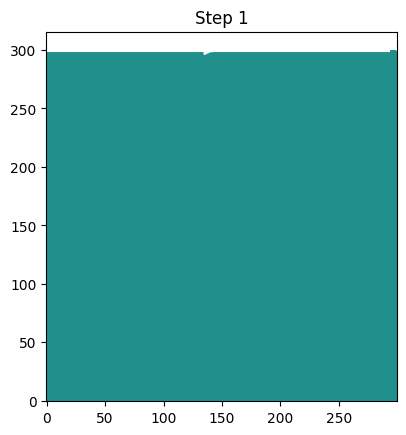

%px:   0%|          | 0/4 [00:00<?, ?tasks/s]

[output:0]

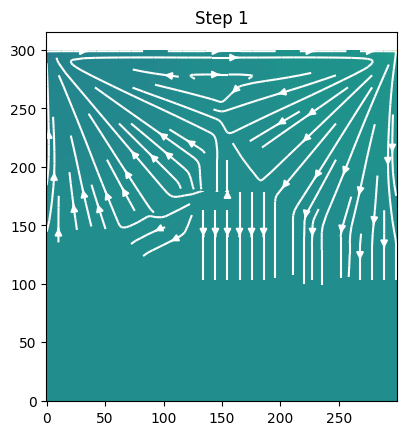

[output:0]

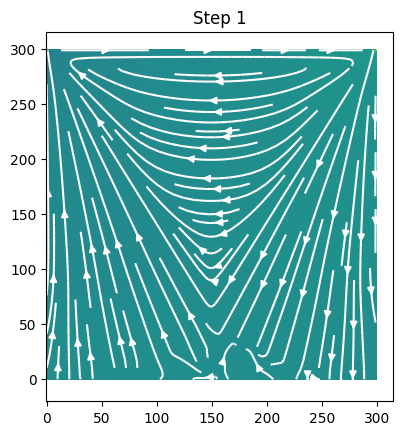

[output:0]

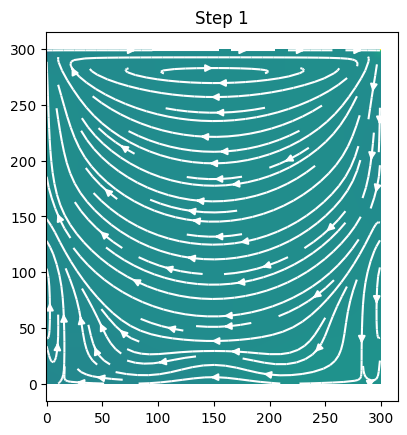

[output:0]

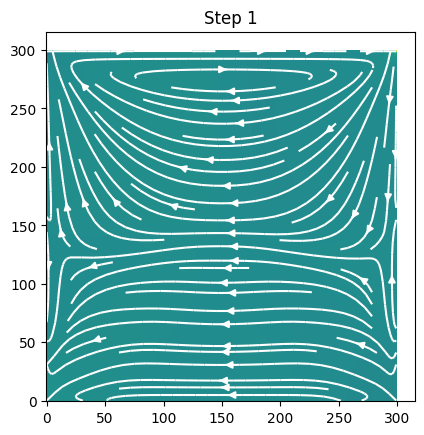

[output:0]

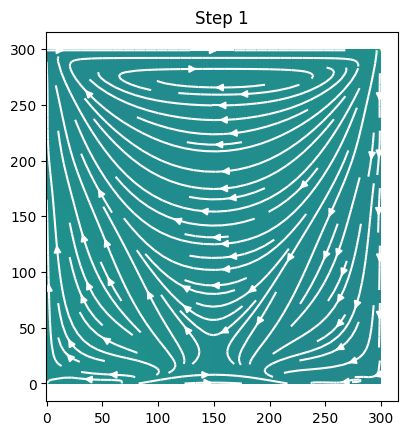

[output:0]

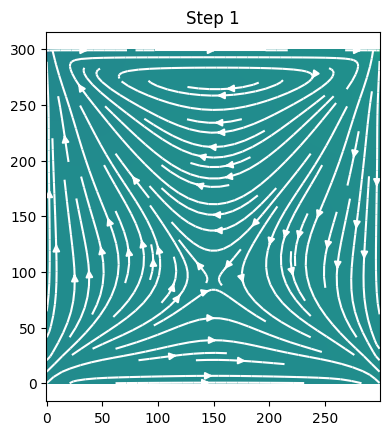

[output:0]

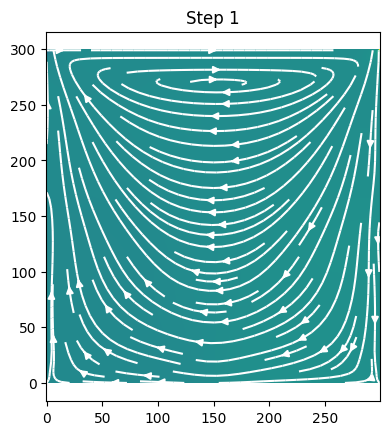

[output:0]

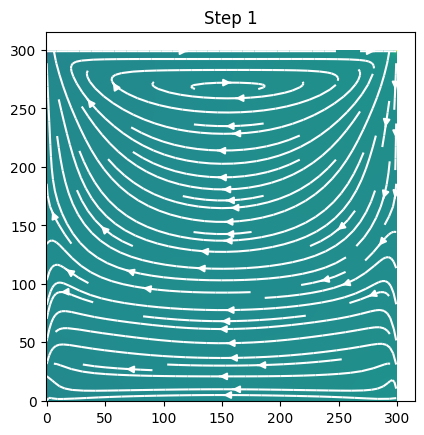

[output:0]

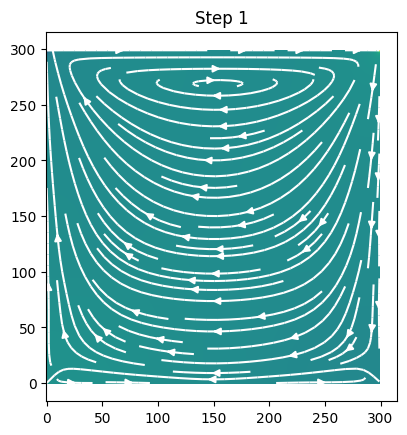

In [48]:
%%px

f = np.einsum("i,jk->ijk", w_i, np.ones((NX, NY)))
# f[:, 8,8] = 0.99*f[:, 8, 8]
# print(f.shape)
config_title = f"Sliding Lid flow - Omega:{omega};"
u_periodic, _, _, _, _ = \
simulate_sliding_lid(f, 2000, 200, config_title)
# u_periodic = stream_loop(f, 10000, 1000, plot=True)